In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# [-1, 1]의 범위로 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

# train 데이터셋 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# test 데이터셋 로드
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# 클래스 레이블
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:03<00:00, 48621063.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


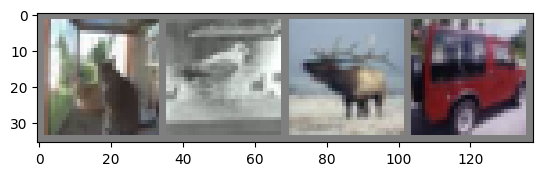

cat   bird  deer  car  


In [6]:
#학습용 이미지
import matplotlib.pyplot as plt
import numpy as np

#이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()


#학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

#이미지 보여주기
imshow(torchvision.utils.make_grid(images))

#정답 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
#합성곱 신경망 정의하기

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
#손실 함수와 Optimizer 정의하기
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

In [10]:
#신경망 학습
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.219
[1,  4000] loss: 1.838
[1,  6000] loss: 1.673
[1,  8000] loss: 1.575
[1, 10000] loss: 1.527
[1, 12000] loss: 1.481
[2,  2000] loss: 1.407
[2,  4000] loss: 1.391
[2,  6000] loss: 1.374
[2,  8000] loss: 1.352
[2, 10000] loss: 1.310
[2, 12000] loss: 1.289
Finished Training


In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

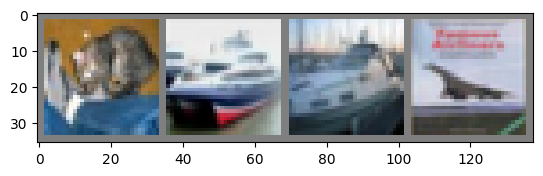

GroundTruth:  cat   ship  ship  plane


In [13]:
#시험용 데이터로 신경망 검사하기
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  frog  ship  ship  plane


In [16]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total}%')

Accuracy of the network on the 10000 test images: 54%


In [17]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] +=1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f}%')

Accuracy for class: plane is 69.3%
Accuracy for class: car   is 67.8%
Accuracy for class: bird  is 35.3%
Accuracy for class: cat   is 18.4%
Accuracy for class: deer  is 53.5%
Accuracy for class: dog   is 49.5%
Accuracy for class: frog  is 74.4%
Accuracy for class: horse is 60.5%
Accuracy for class: ship  is 58.0%
Accuracy for class: truck is 55.1%
